### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.base import clone

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,auc,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, make_scorer
)


### Data Loading and Initial Exploration

In this step, we load the SECOM dataset from Google Drive into a pandas DataFrame. The target labels in the `Pass/Fail` column are converted for consistency, where `1` indicates a **pass** and `0` indicates a **fail**. We then display the dataset's shape, a summary of the class distribution, the first few rows, and key statistics such as column-wise descriptions and data types to understand the structure and quality of the data.


In [ ]:
file_path = "../data/uci-secom.csv"
df = pd.read_csv(file_path)

df['Pass/Fail'] = df['Pass/Fail'].replace({1: 0, -1: 1}) # Pass = 1 , Fail = 0

print("Data shape:", df.shape)
print(df['Pass/Fail'].value_counts())
df.head()

Data shape: (1567, 592)
Pass/Fail
1    1463
0     104
Name: count, dtype: int64


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


<Axes: ylabel='Frequency'>

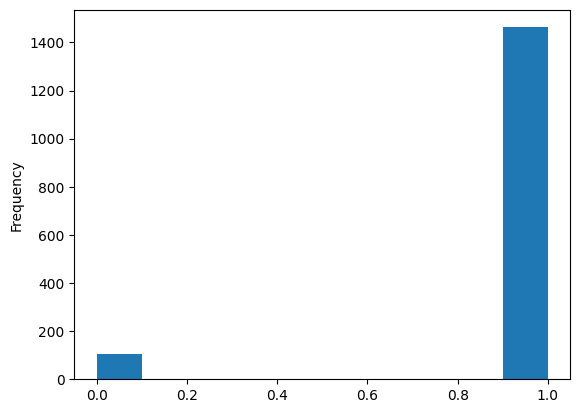

In [5]:
df['Pass/Fail'].plot.hist()

### Missing Data Analysis

This section analyzes missing values in the dataset. First, it calculates the percentage of missing values for each column and categorizes them into bins (e.g., 0–10%, 10–20%, etc.) to understand the overall distribution of missing data. A bar plot is then generated to visualize the top 50 features with the highest percentage of missing values. Finally, the number of features with more than 50% missing data is reported, which is important for deciding how to handle or remove unreliable features.


In [6]:
nan_percentage = df.isna().mean() * 100

bins = list(range(0, 110, 10))
labels = [f"{i}-{i+10}%" for i in bins[:-1]]
binned = pd.cut(nan_percentage, bins=bins, labels=labels, right=False)

nan_distribution = binned.value_counts().sort_index()

print(nan_distribution)

0-10%      540
10-20%      20
20-30%       0
30-40%       0
40-50%       4
50-60%       4
60-70%      16
70-80%       0
80-90%       4
90-100%      4
Name: count, dtype: int64


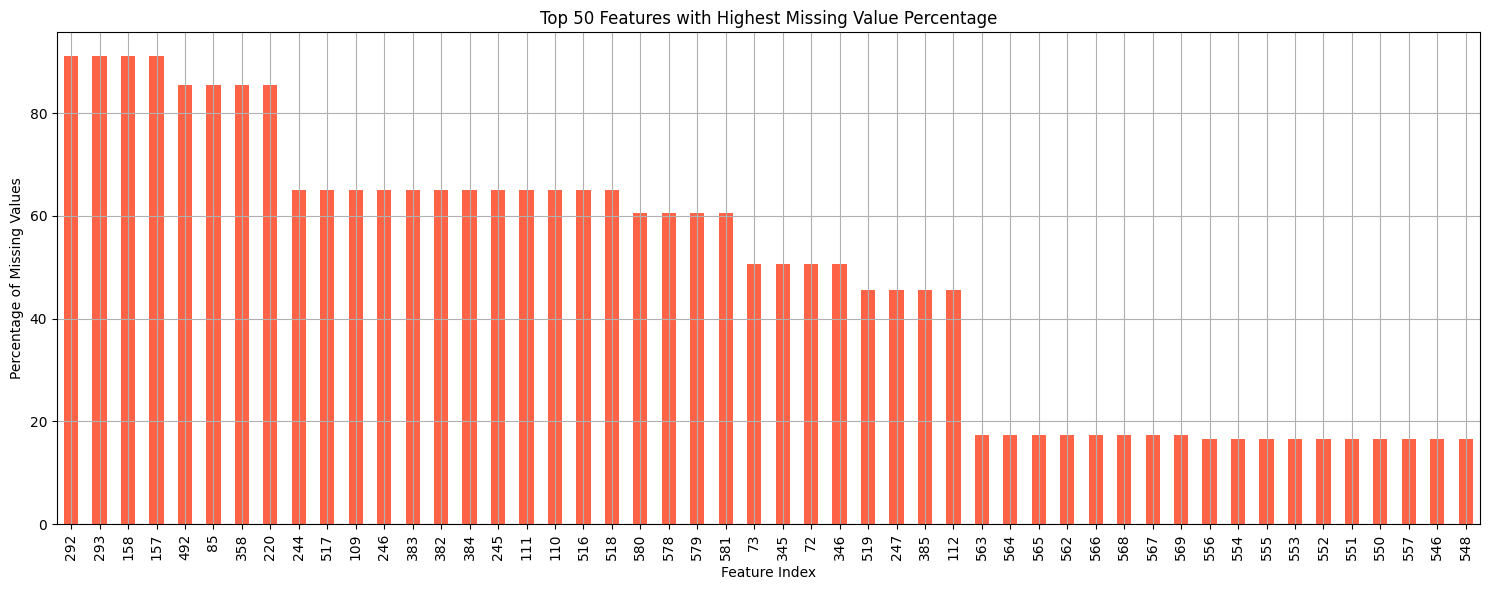


Number of columns with > 50% NaNs: 28


In [7]:
features_only = df.drop(columns=['Pass/Fail', 'Time'])
missing_percent = features_only.isnull().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)

plt.figure(figsize=(15, 6))
missing_percent[:50].plot(kind='bar', color='tomato')
plt.title("Top 50 Features with Highest Missing Value Percentage")
plt.ylabel("Percentage of Missing Values")
plt.xlabel("Feature Index")
plt.grid(True)
plt.tight_layout()
plt.show()

high_nan_columns = missing_percent[missing_percent > 50]
print(f"\nNumber of columns with > 50% NaNs: {len(high_nan_columns)}")


### Data Preprocessing: Handling Missing Values and Scaling

In this step, we prepare the dataset for modeling by separating features (`X`) from the target (`y`) and handling missing values. Missing data in each feature column is filled using a **rolling median** with a window size of 11 (centered), which helps preserve local trends while smoothing noise. For any remaining missing values (typically at the edges), we apply a fallback by filling them with the column median. Finally, the features are standardized using `StandardScaler` to ensure all variables contribute equally to the model, improving training performance and convergence.


In [8]:
X = df.drop(columns=['Pass/Fail', 'Time'], errors='ignore')
y = df['Pass/Fail'].values

# Apply rolling median per column to fill missing values
# Window size: 11 (5 before + 5 after + current)
window_size = 11
X_rolled = X.copy()

for col in X_rolled.columns:
    if X_rolled[col].isna().any():
        X_rolled[col] = X_rolled[col].fillna(
            X_rolled[col].rolling(window=window_size, center=True, min_periods=1).median()
        )

# Fill any remaining NaNs (e.g. at edges) using column median as fallback
X_rolled = X_rolled.fillna(X_rolled.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rolled)


### Feature Importance and Selection using Tree-Based Models

In this section, we evaluate feature importance using two ensemble methods: **ExtraTreesClassifier** and **RandomForestClassifier**. Both models are trained on the scaled feature set, and feature importances are extracted to identify the most relevant predictors of product quality (`Pass/Fail`).

- **ExtraTreesClassifier**: A highly randomized tree ensemble that often yields robust importance estimates.
- **RandomForestClassifier**: A widely used ensemble model; here, it's configured with `class_weight='balanced'` to account for any class imbalance.

#### Key Steps:
1. **Feature Importance Calculation**: Importance scores from both models are saved and compared side by side for the top 20 features using a horizontal bar plot.
2. **Feature Selection**: To reduce dimensionality while preserving predictive power, we select features that collectively account for **90% of the total importance** in each model.
3. **Reduced Feature Sets**: Two separate reduced datasets are created (one for ExtraTrees and one for RandomForest) using only the selected features.

This process helps identify the most influential features and enables the construction of simpler, faster, and potentially more interpretable models downstream.


In [9]:
# Train ExtraTreesClassifier
et_model = ExtraTreesClassifier(n_estimators=300, random_state=42)
et_model.fit(X_scaled, y)

et_importances = et_model.feature_importances_

# Save to DataFrame
importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': et_importances
}).sort_values(by='importance', ascending=False)


In [10]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
rf_model.fit(X_scaled, y)

rf_importances = rf_model.feature_importances_

# Create DataFrame
rf_importances_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_importances
}).sort_values(by='rf_importance', ascending=False)


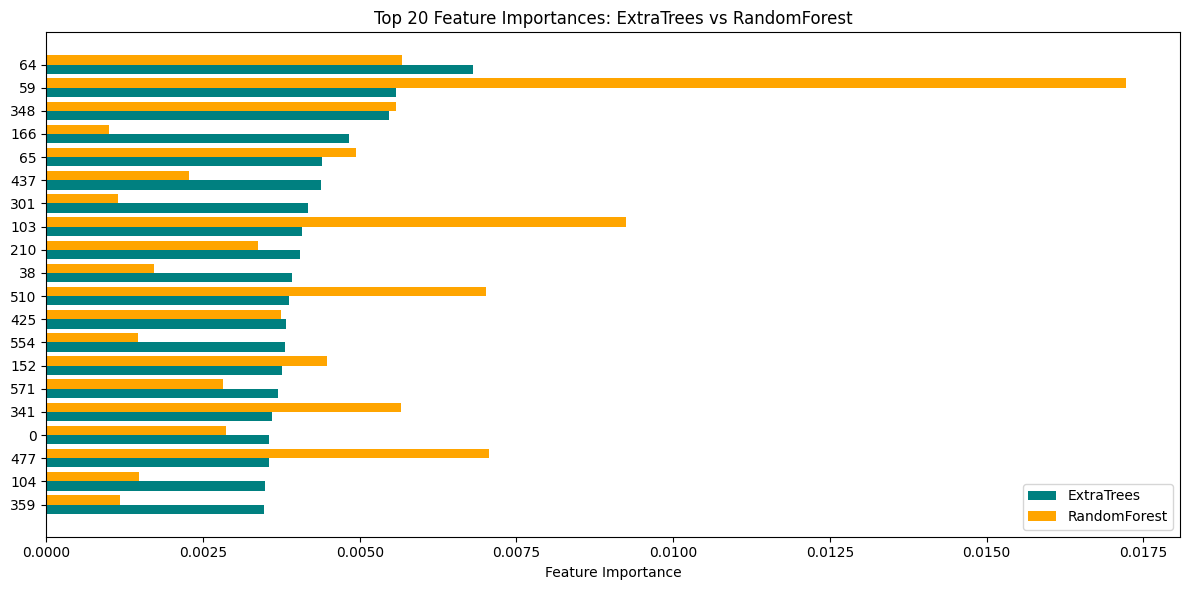

In [11]:
# Merge with ExtraTrees importances
merged_importances = importances_df.merge(rf_importances_df, on='feature')

# Plot both side by side
top_n = 20
top_features = merged_importances.head(top_n)

plt.figure(figsize=(12, 6))
bar_width = 0.4
indices = range(top_n)

plt.barh([i + bar_width for i in indices], top_features['importance'], height=bar_width, label='ExtraTrees', color='teal')
plt.barh(indices, top_features['rf_importance'], height=bar_width, label='RandomForest', color='orange')
plt.yticks([i + bar_width/2 for i in indices], top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances: ExtraTrees vs RandomForest')
plt.legend()
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [12]:
# === From ExtraTrees ===
threshold_et = 0.90  # Keep features that explain 90% of total importance
et_cum_importance = importances_df['importance'].cumsum()
et_selected_features = importances_df[et_cum_importance <= threshold_et]['feature'].tolist()

# Create reduced feature DataFrame for ExtraTrees
X_et = X_scaled[:, [X.columns.get_loc(feat) for feat in et_selected_features]]
et_df = pd.DataFrame(X_et, columns=et_selected_features)
et_df['Pass/Fail'] = y

print(f"ExtraTrees selected {len(et_selected_features)} features.")

# === From RandomForest ===
threshold_rf = 0.90
rf_cum_importance = rf_importances_df['rf_importance'].cumsum()
rf_selected_features = rf_importances_df[rf_cum_importance <= threshold_rf]['feature'].tolist()

# Create reduced feature DataFrame for RandomForest
X_rf = X_scaled[:, [X.columns.get_loc(feat) for feat in rf_selected_features]]
rf_df = pd.DataFrame(X_rf, columns=rf_selected_features)
rf_df['Pass/Fail'] = y

print(f"RandomForest selected {len(rf_selected_features)} features.")

ExtraTrees selected 391 features.
RandomForest selected 367 features.


Create new DFs that doesn't contain the features that has the most importance based on the RF and ET classifiers.

In [13]:
et_df_no_64 = et_df.drop(columns=["64"], errors="ignore")

rf_df_no_59 = rf_df.drop(columns=["59"], errors="ignore")

### Correlation Analysis, Feature Reduction, and PCA on Selected Features

After selecting important features from the ExtraTrees and RandomForest models, we further analyze their relationships and reduce redundancy:

1. **Correlation Heatmaps**  
   We compute and visualize correlation matrices for both sets of selected features to identify highly correlated variables. Strong correlations may indicate redundant information that can negatively impact model performance or interpretability.

2. **Removing Highly Correlated Features**  
   Using a threshold (default 0.9), we automatically drop features that are highly correlated with others in the dataset. This step reduces multicollinearity and simplifies the feature space.

3. **Applying PCA for Dimensionality Reduction**  
   Principal Component Analysis (PCA) is applied twice:  
   - On the original selected feature sets.  
   - On the de-correlated (cleaned) feature sets.  
   
   PCA transforms the features into a smaller set of orthogonal components that preserve 95% of the variance, further simplifying the data while retaining most of its information.

This multi-step process ensures that the final features used for modeling are both important and minimally redundant, leading to more efficient and robust models.


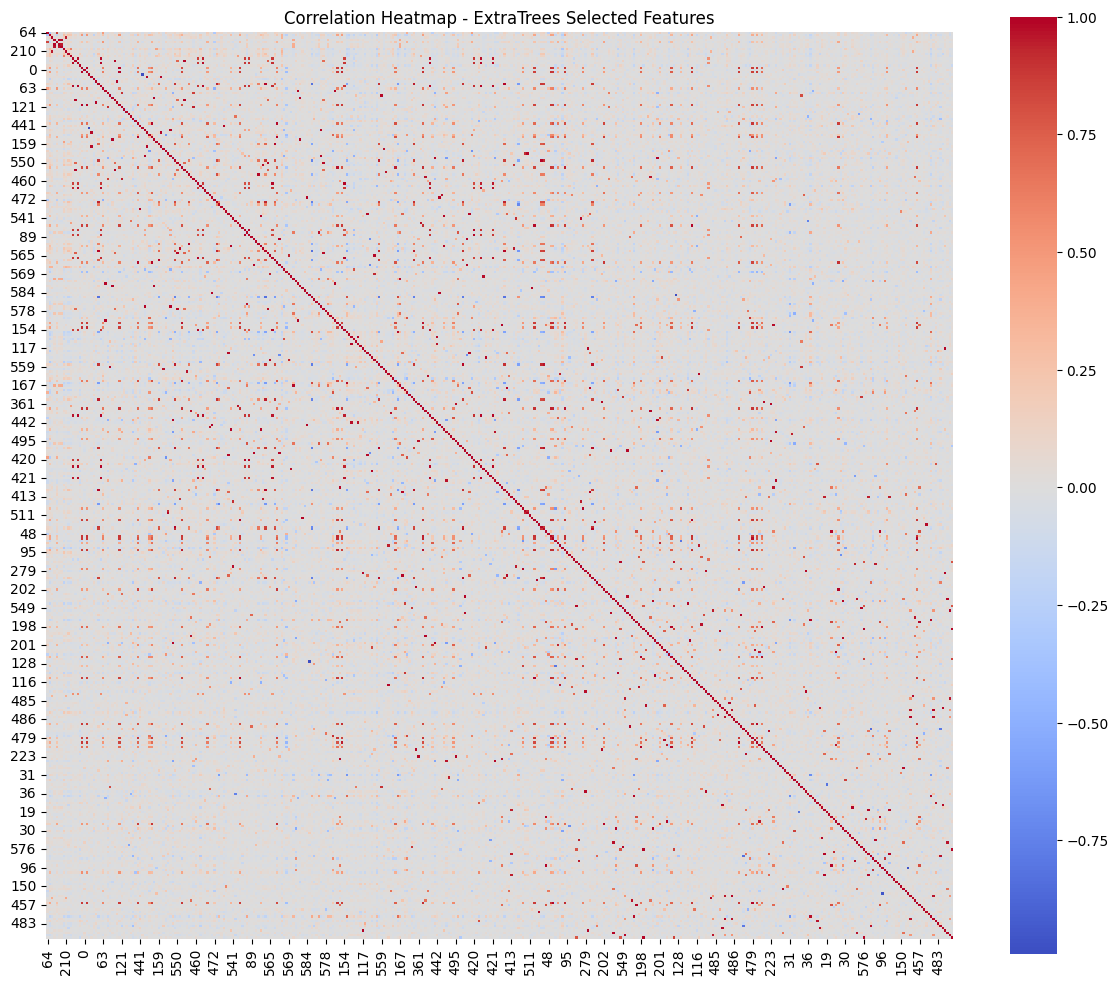

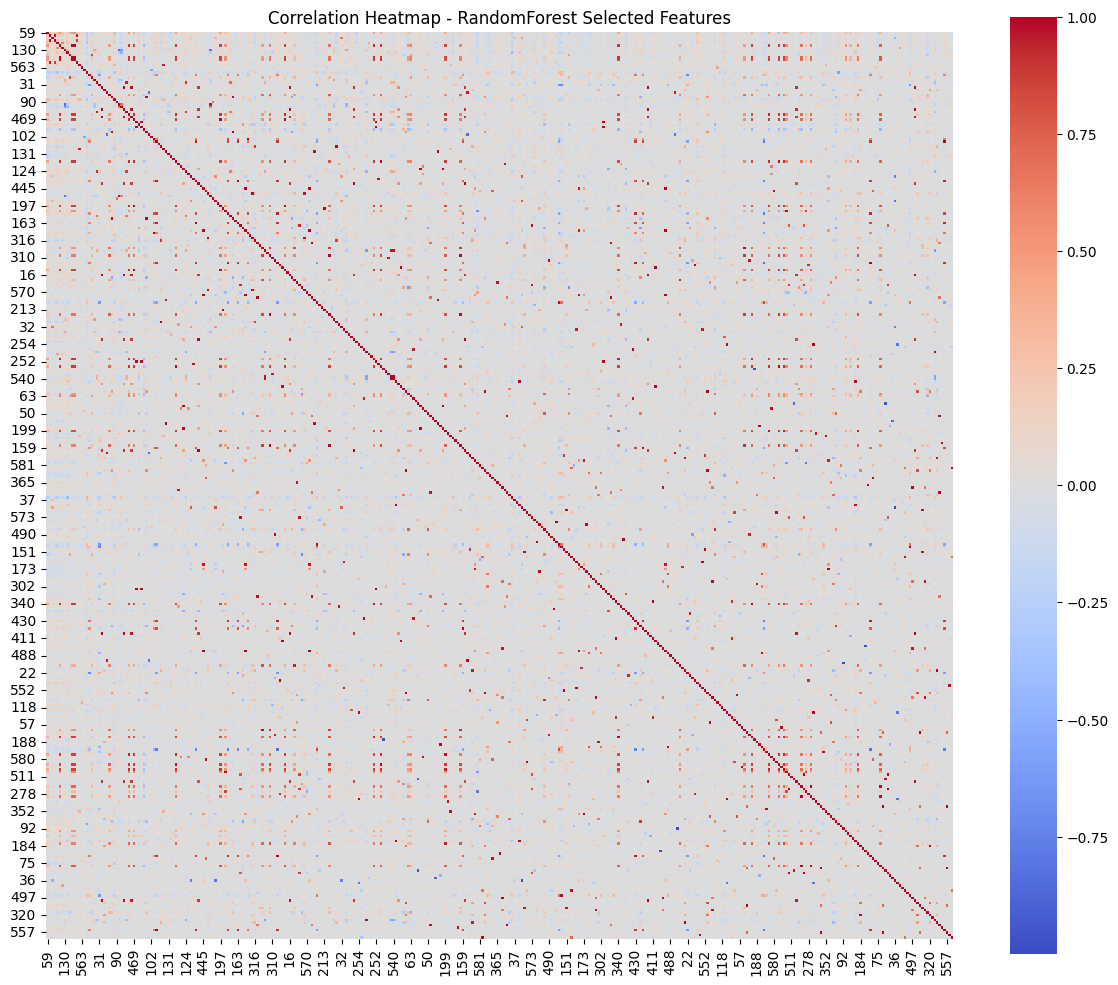

In [14]:
# Remove target column before correlation
et_corr = et_df.drop(columns='Pass/Fail').corr()
rf_corr = rf_df.drop(columns='Pass/Fail').corr()

# === ExtraTrees correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(et_corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap - ExtraTrees Selected Features")
plt.tight_layout()
plt.show()

# === RandomForest correlation heatmap ===
plt.figure(figsize=(12, 10))
sns.heatmap(rf_corr, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap - RandomForest Selected Features")
plt.tight_layout()
plt.show()

In [15]:
# Function to drop highly correlated features
def drop_highly_correlated(df, threshold=0.95):
    X = df.drop(columns='Pass/Fail')
    y = df['Pass/Fail']
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Dropping {len(to_drop)} highly correlated features (correlation > {threshold})")
    reduced_df = X.drop(columns=to_drop)
    reduced_df['Pass/Fail'] = y
    return reduced_df

# Clean versions of your selected feature sets
et_df_uncorr = drop_highly_correlated(et_df, threshold=0.9)
rf_df_uncorr = drop_highly_correlated(rf_df, threshold=0.9)

# Without most important feature 
et_df_no_64_uncorr = drop_highly_correlated(et_df_no_64, threshold=0.9)
rf_df_no_59_uncorr = drop_highly_correlated(rf_df_no_59, threshold=0.9)

Dropping 163 highly correlated features (correlation > 0.9)
Dropping 140 highly correlated features (correlation > 0.9)
Dropping 163 highly correlated features (correlation > 0.9)
Dropping 140 highly correlated features (correlation > 0.9)


In [16]:
# Function to apply PCA to any feature set (excluding target)
def apply_pca(df, variance_threshold=0.90):
    X_sel = df.drop(columns='Pass/Fail').values
    y_sel = df['Pass/Fail'].values
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_pca = pca.fit_transform(X_sel)
    print(f"PCA reduced from {X_sel.shape[1]} to {X_pca.shape[1]} components to preserve {variance_threshold*100:.0f}% variance.")
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    pca_df['Pass/Fail'] = y_sel
    return pca_df

In [17]:
# PCA on correlated feature sets
et_pca_df = apply_pca(et_df)
rf_pca_df = apply_pca(rf_df)

# PCA on de-correlated feature sets
et_pca_uncorr_df = apply_pca(et_df_uncorr)
rf_pca_uncorr_df = apply_pca(rf_df_uncorr)

# PCA on correlated features without the most important
et_pca_no_64_df = apply_pca(et_df_no_64)
rf_pca_no_59_df = apply_pca(rf_df_no_59)

# PCA on de-correlated features without the most important
et_pca_no_64_uncorr_df = apply_pca(et_df_no_64_uncorr)
rf_pca_no_59_uncorr_df = apply_pca(rf_df_no_59_uncorr)

PCA reduced from 391 to 121 components to preserve 90% variance.
PCA reduced from 367 to 122 components to preserve 90% variance.
PCA reduced from 228 to 128 components to preserve 90% variance.
PCA reduced from 227 to 128 components to preserve 90% variance.
PCA reduced from 390 to 121 components to preserve 90% variance.
PCA reduced from 366 to 122 components to preserve 90% variance.
PCA reduced from 227 to 128 components to preserve 90% variance.
PCA reduced from 226 to 127 components to preserve 90% variance.


In [18]:
splits = {}

def split_data(df, name, test_size=0.2, random_state=42):
    X = df.drop(columns='Pass/Fail').values
    y = df['Pass/Fail'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    splits[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"[{name}]: Train: {X_train.shape}, Test: {X_test.shape}, Class balance (train): {np.bincount(y_train)}, (test): {np.bincount(y_test)}")


In [19]:
split_data(et_df, "ET_raw")
split_data(rf_df, "RF_raw")
split_data(et_df_uncorr, "ET_uncorr")
split_data(rf_df_uncorr, "RF_uncorr")
split_data(et_pca_df, "ET_PCA")
split_data(rf_pca_df, "RF_PCA")
split_data(et_pca_uncorr_df, "ET_PCA_uncorr")
split_data(rf_pca_uncorr_df, "RF_PCA_uncorr")

[ET_raw]: Train: (1253, 391), Test: (314, 391), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_raw]: Train: (1253, 367), Test: (314, 367), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_uncorr]: Train: (1253, 228), Test: (314, 228), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_uncorr]: Train: (1253, 227), Test: (314, 227), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA]: Train: (1253, 121), Test: (314, 121), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA]: Train: (1253, 122), Test: (314, 122), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]


In [20]:
split_data(et_df_no_64, "ET_NO_64")
split_data(rf_df_no_59, "RF_NO_59")
split_data(et_df_no_64_uncorr, "ET_NO_64_uncorr")
split_data(rf_df_no_59_uncorr, "RF_NO_59_uncorr")
split_data(et_pca_no_64_df, "ET_PCA_NO_64")
split_data(rf_pca_no_59_df, "RF_PCA_NO_59")
split_data(et_pca_no_64_uncorr_df, "ET_PCA_NO_64_uncorr")
split_data(rf_pca_no_59_uncorr_df, "RF_PCA_NO_59_uncorr")


[ET_NO_64]: Train: (1253, 390), Test: (314, 390), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_NO_59]: Train: (1253, 366), Test: (314, 366), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_NO_64_uncorr]: Train: (1253, 227), Test: (314, 227), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_NO_59_uncorr]: Train: (1253, 226), Test: (314, 226), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_NO_64]: Train: (1253, 121), Test: (314, 121), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_NO_59]: Train: (1253, 122), Test: (314, 122), Class balance (train): [  83 1170], (test): [ 21 293]
[ET_PCA_NO_64_uncorr]: Train: (1253, 128), Test: (314, 128), Class balance (train): [  83 1170], (test): [ 21 293]
[RF_PCA_NO_59_uncorr]: Train: (1253, 127), Test: (314, 127), Class balance (train): [  83 1170], (test): [ 21 293]


In [21]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=12, random_state=42)
}

# Dictionary to store CV results
cv_results = {}

def run_cross_validation(dataset_name, cv_folds=7):
    data = splits[dataset_name]
    X, y = data['X_train'], data['y_train']

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    results = []

    for name, model in models.items():
        print(f"Training {name} on {dataset_name}...")

        scores = cross_validate(
            model, X, y,
            cv=skf,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            return_train_score=False,
            n_jobs=-1
        )

        results.append({
            'Model': name,
            'Dataset': dataset_name,
            'Accuracy':  scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall':    scores['test_recall'].mean(),
            'F1 Score':  scores['test_f1'].mean(),
            'ROC AUC':   scores['test_roc_auc'].mean(),
            'Fit Time':  scores['fit_time'].mean()
        })

    # Save to global results dictionary
    cv_results[dataset_name] = pd.DataFrame(results)
    print(f"\nCross-validation completed for {dataset_name}\n")


In [22]:
for dataset_name in splits.keys():
    run_cross_validation(dataset_name)

Training LogisticRegression on ET_raw...


Training RandomForest on ET_raw...
Training DecisionTree on ET_raw...
Training GaussianNB on ET_raw...
Training KNN on ET_raw...
Training SVC on ET_raw...
Training XGBoost on ET_raw...

Cross-validation completed for ET_raw

Training LogisticRegression on RF_raw...
Training RandomForest on RF_raw...
Training DecisionTree on RF_raw...
Training GaussianNB on RF_raw...
Training KNN on RF_raw...
Training SVC on RF_raw...
Training XGBoost on RF_raw...

Cross-validation completed for RF_raw

Training LogisticRegression on ET_uncorr...
Training RandomForest on ET_uncorr...
Training DecisionTree on ET_uncorr...
Training GaussianNB on ET_uncorr...
Training KNN on ET_uncorr...
Training SVC on ET_uncorr...
Training XGBoost on ET_uncorr...

Cross-validation completed for ET_uncorr

Training LogisticRegression on RF_uncorr...
Training RandomForest on RF_uncorr...
Training DecisionTree on RF_uncorr...
Training GaussianNB on RF_uncorr...
Training KNN on RF_uncorr...
Training SVC on RF_uncorr...
Train

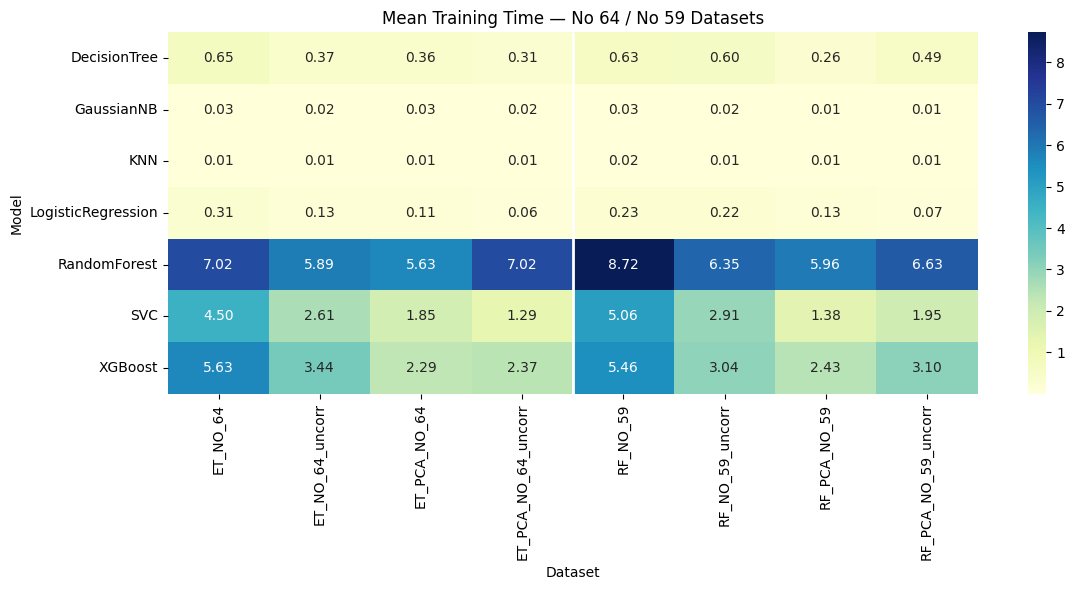

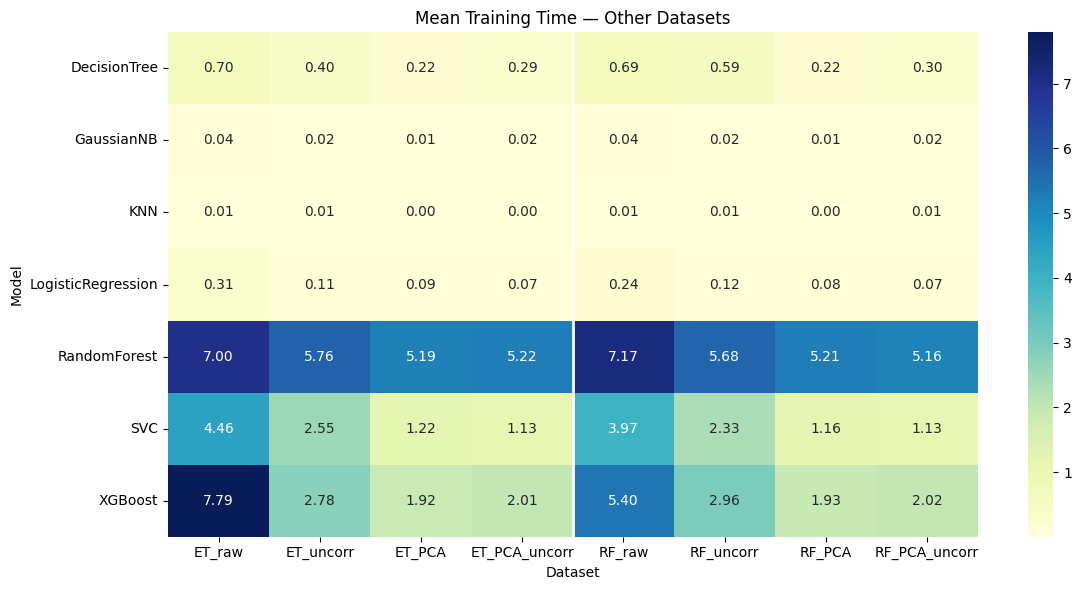

In [23]:
# Aggregate across datasets
all_cv_df = pd.concat(cv_results.values(), ignore_index=True)

# Define consistent dataset order
ordered_datasets = [
    "ET_raw", "ET_uncorr", "ET_PCA", "ET_PCA_uncorr",
    "RF_raw", "RF_uncorr", "RF_PCA", "RF_PCA_uncorr",
    "ET_NO_64", "ET_NO_64_uncorr", "ET_PCA_NO_64", "ET_PCA_NO_64_uncorr",
    "RF_NO_59", "RF_NO_59_uncorr", "RF_PCA_NO_59", "RF_PCA_NO_59_uncorr"
]
ordered_datasets = [ds for ds in ordered_datasets if ds in all_cv_df['Dataset'].unique()]

# Target group
target_datasets = [
    "ET_NO_64", "RF_NO_59",
    "ET_NO_64_uncorr", "RF_NO_59_uncorr",
    "ET_PCA_NO_64", "RF_PCA_NO_59",
    "ET_PCA_NO_64_uncorr", "RF_PCA_NO_59_uncorr"
]

# Helper to plot heatmap with vertical gaps
def plot_heatmap_with_gaps(df, title, split_after_labels):
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Dataset")
    plt.ylabel("Model")

    # Add vertical lines after certain labels
    for split_label in split_after_labels:
        if split_label in df.columns:
            idx = list(df.columns).index(split_label) + 1
            ax.vlines(idx, *ax.get_ylim(), colors='white', linewidth=2)

    plt.tight_layout()
    plt.show()

# Group 1: No 64 / No 59 datasets
time_mat_target = all_cv_df[all_cv_df['Dataset'].isin(target_datasets)].pivot(
    index='Model', columns='Dataset', values='Fit Time'
    ).reindex(
        columns=[ds for ds in ordered_datasets if ds in target_datasets]
    )

# Gap between ET_* and RF_* datasets
plot_heatmap_with_gaps(time_mat_target, "Mean Training Time — No 64 / No 59 Datasets",
                       split_after_labels=["ET_PCA_NO_64_uncorr"])

# Group 2: Other datasets
time_mat_other = all_cv_df[~all_cv_df['Dataset'].isin(target_datasets)] \
    .pivot(index='Model', columns='Dataset', values='Fit Time') \
    .reindex(columns=[ds for ds in ordered_datasets if ds not in target_datasets])

# Gap between ET_* and RF_* datasets
plot_heatmap_with_gaps(time_mat_other, "Mean Training Time — Other Datasets",
                       split_after_labels=["ET_PCA_uncorr"])

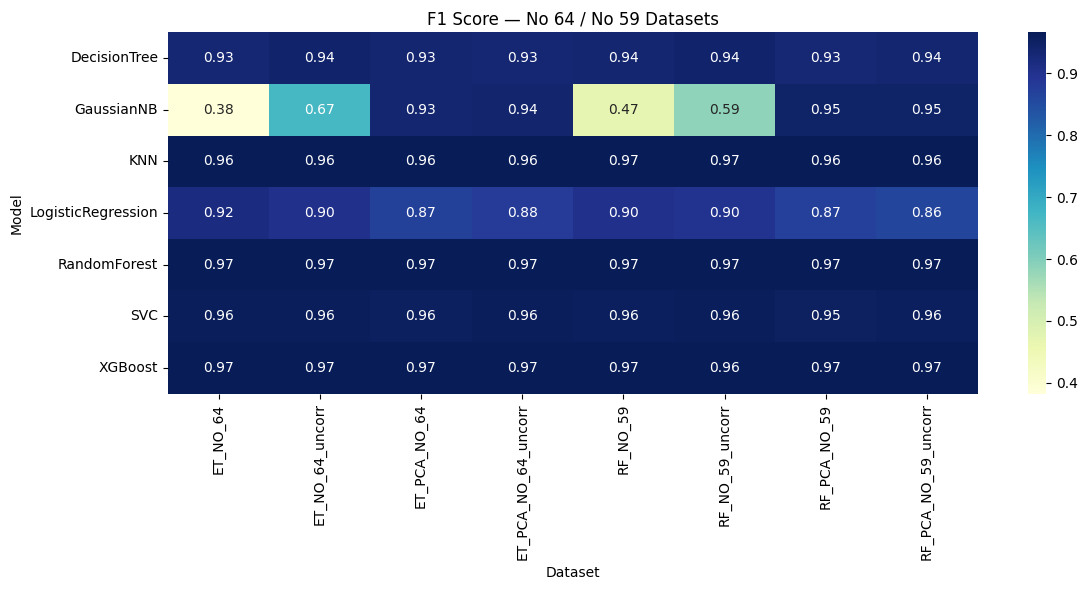

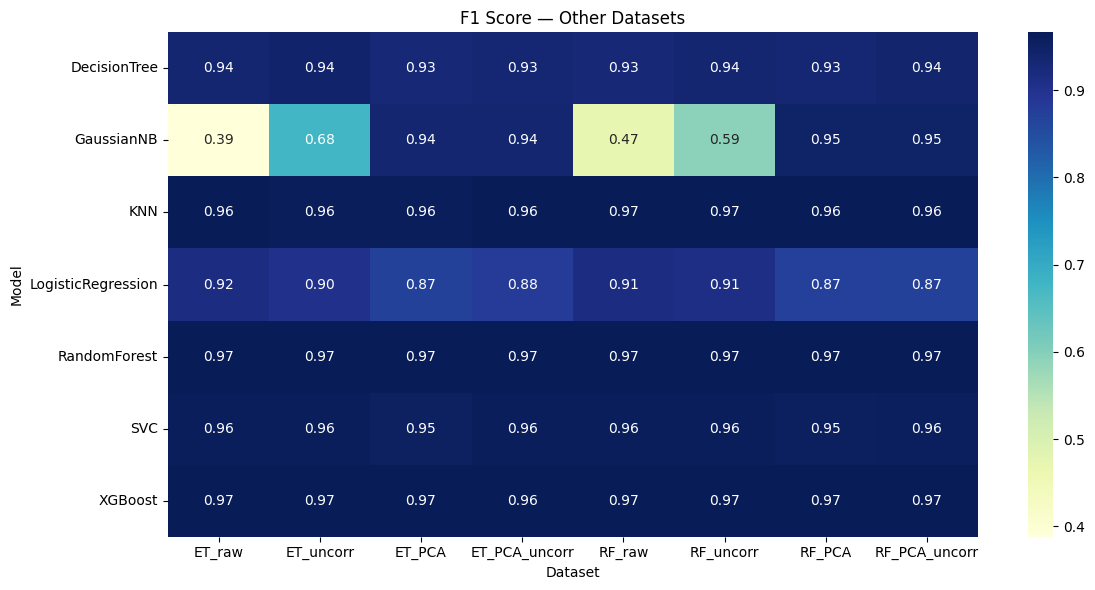

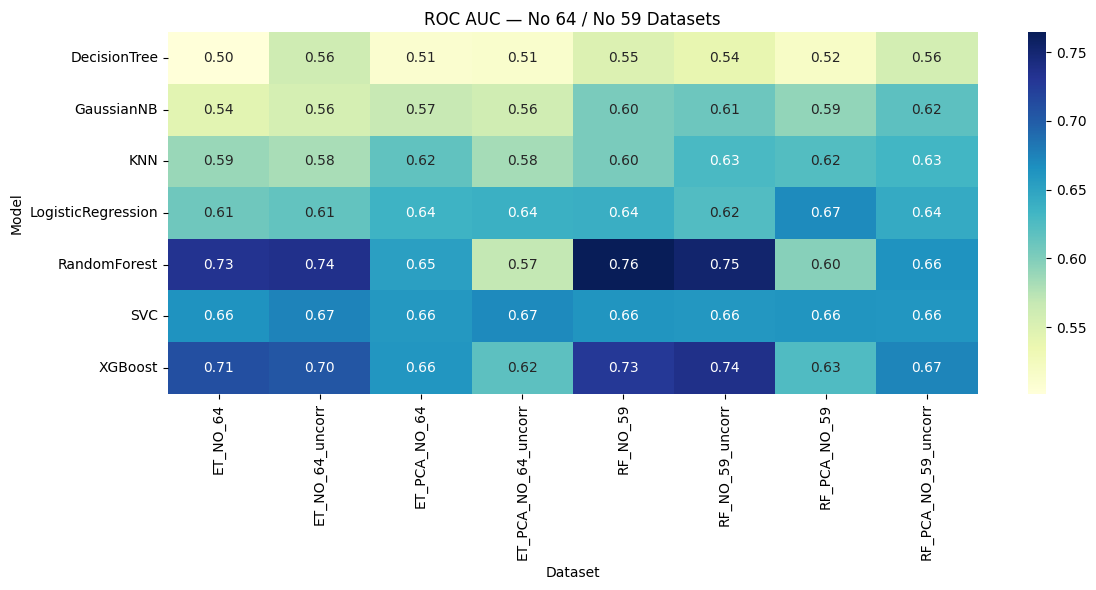

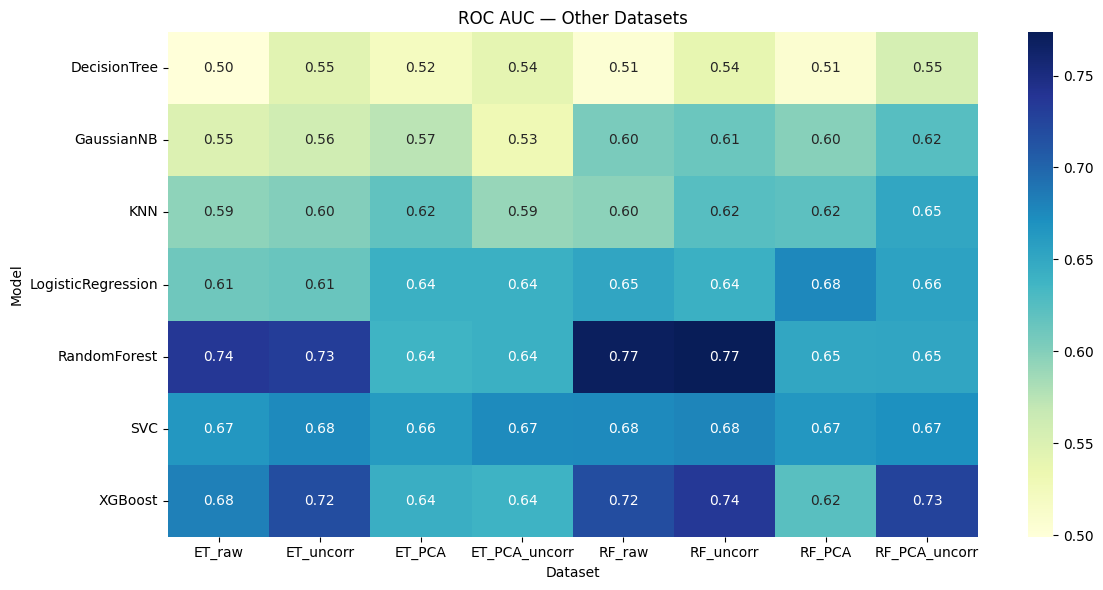

In [24]:
def plot_metric_heatmaps(metric='F1 Score', cmap='YlGnBu'):
    combined = pd.concat(cv_results.values(), ignore_index=True)

    # Group 1: No 64 / No 59 datasets
    pivot_target = combined[combined['Dataset'].isin(target_datasets)] \
        .pivot(index='Model', columns='Dataset', values=metric) \
        .reindex(columns=[ds for ds in ordered_datasets if ds in target_datasets])
    
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(pivot_target, annot=True, fmt=".2f", cmap=cmap)
    plt.title(f'{metric} — No 64 / No 59 Datasets')
    plt.tight_layout()
    plt.show()

    # Group 2: Other datasets
    pivot_other = combined[~combined['Dataset'].isin(target_datasets)] \
        .pivot(index='Model', columns='Dataset', values=metric) \
        .reindex(columns=[ds for ds in ordered_datasets if ds not in target_datasets])
    
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(pivot_other, annot=True, fmt=".2f", cmap=cmap)
    plt.title(f'{metric} — Other Datasets')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_metric_heatmaps('F1 Score')
plot_metric_heatmaps('ROC AUC')


In [25]:
def plot_top3_roc_subplots(dataset_name, n_splits=5):
    if dataset_name not in cv_results:
        raise KeyError(f"{dataset_name} not found in cv_results. Run run_cross_validation('{dataset_name}') first.")

    # pick top-3 by ROC AUC from your stored results
    top3 = (cv_results[dataset_name]
            .sort_values(by='ROC AUC', ascending=False)
            .head(3)
            .reset_index(drop=True))

    data = splits[dataset_name]
    X, y = data['X_train'], data['y_train'] 

    mean_fpr = np.linspace(0, 1, 200)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # prepare subplots
    n_models = len(top3)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5), sharex=True, sharey=True)

    if n_models == 1:
        axes = [axes]  # make iterable

    for ax, (_, row) in zip(axes, top3.iterrows()):
        model_name = row['Model']
        base_model = models[model_name]
        model = clone(base_model)

        tprs = []
        aucs = []

        # cross-validated ROC
        for train_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            model.fit(X_tr, y_tr)
            probas = model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, probas)

            # interpolate TPR at common FPR grid
            interp = np.interp(mean_fpr, fpr, tpr)
            interp[0] = 0.0
            tprs.append(interp)
            aucs.append(auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = float(np.mean(aucs))

        # plot only mean curve
        ax.plot(mean_fpr, mean_tpr, lw=2)
        ax.plot([0, 1], [0, 1], linestyle='--', lw=1)
        ax.set_title(f"{dataset_name} — {model_name}\nAUC = {mean_auc:.3f}")
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.05)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.grid(True, alpha=0.3)

    fig.suptitle(f"Top 3 Mean ROC Curves — {dataset_name}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:58:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:58:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:58:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:01] WARNI

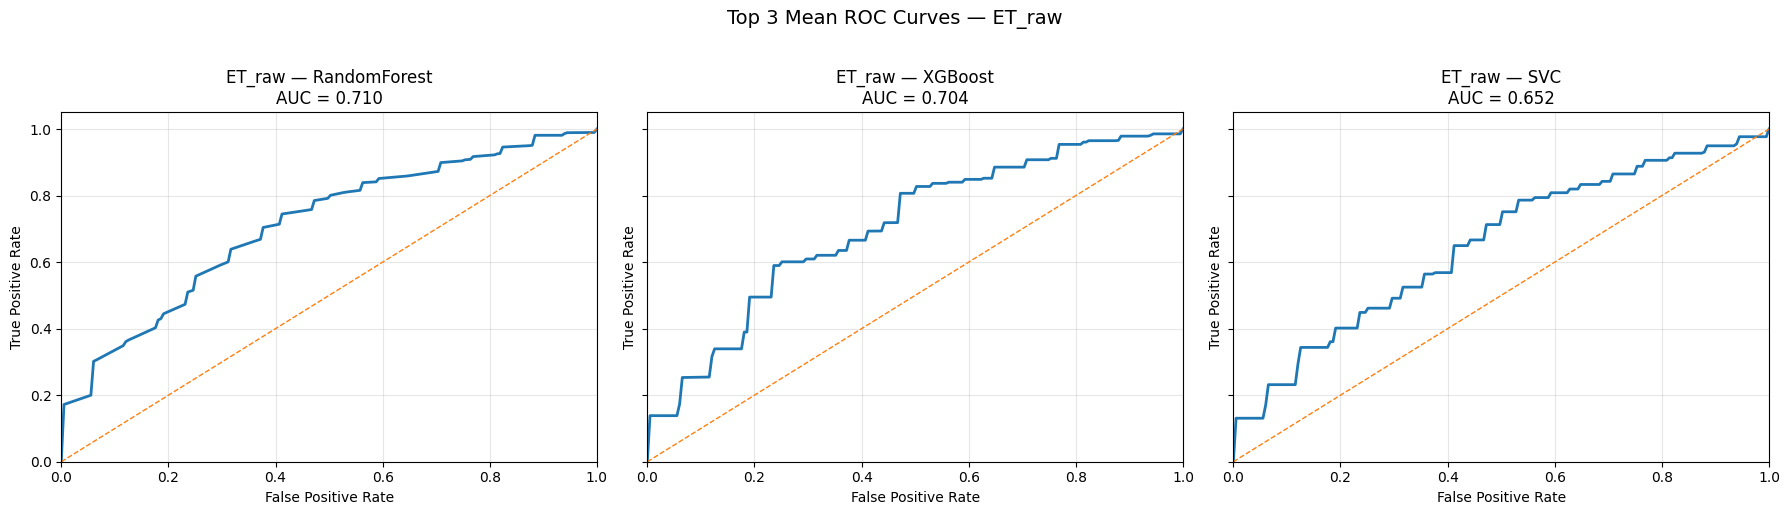

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:36] WARNI

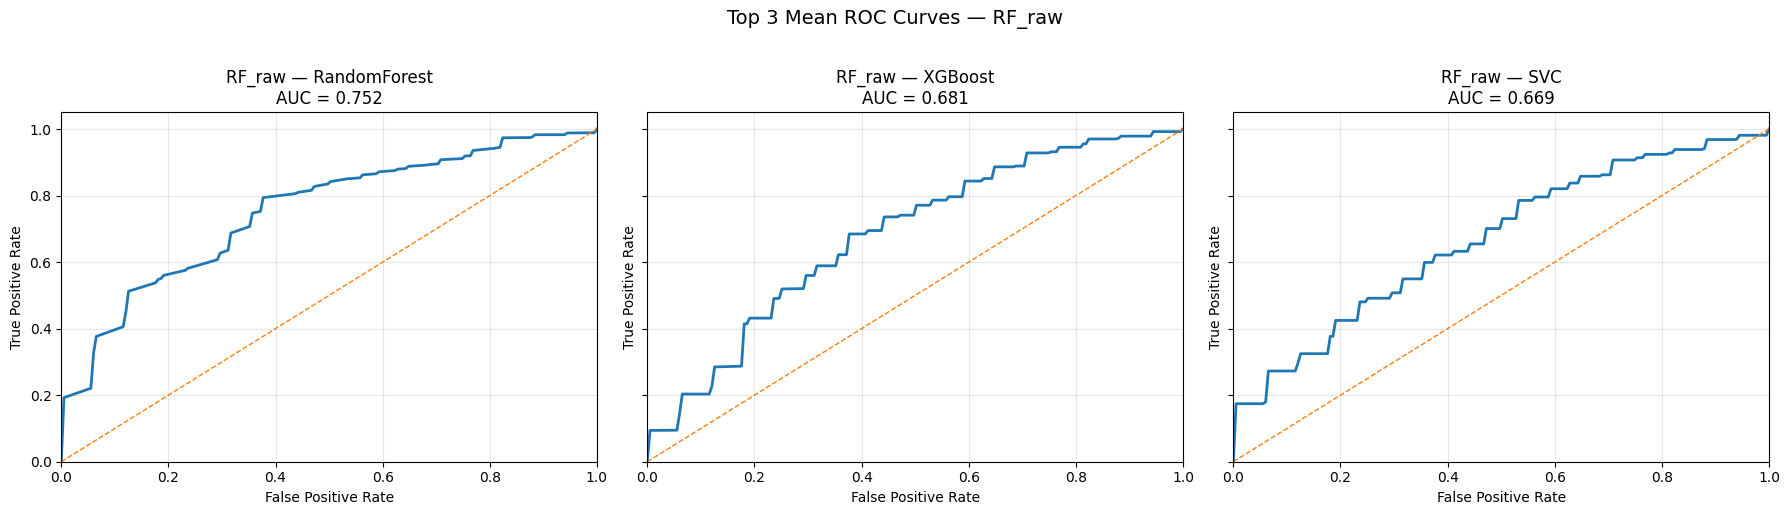

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:04] WARNI

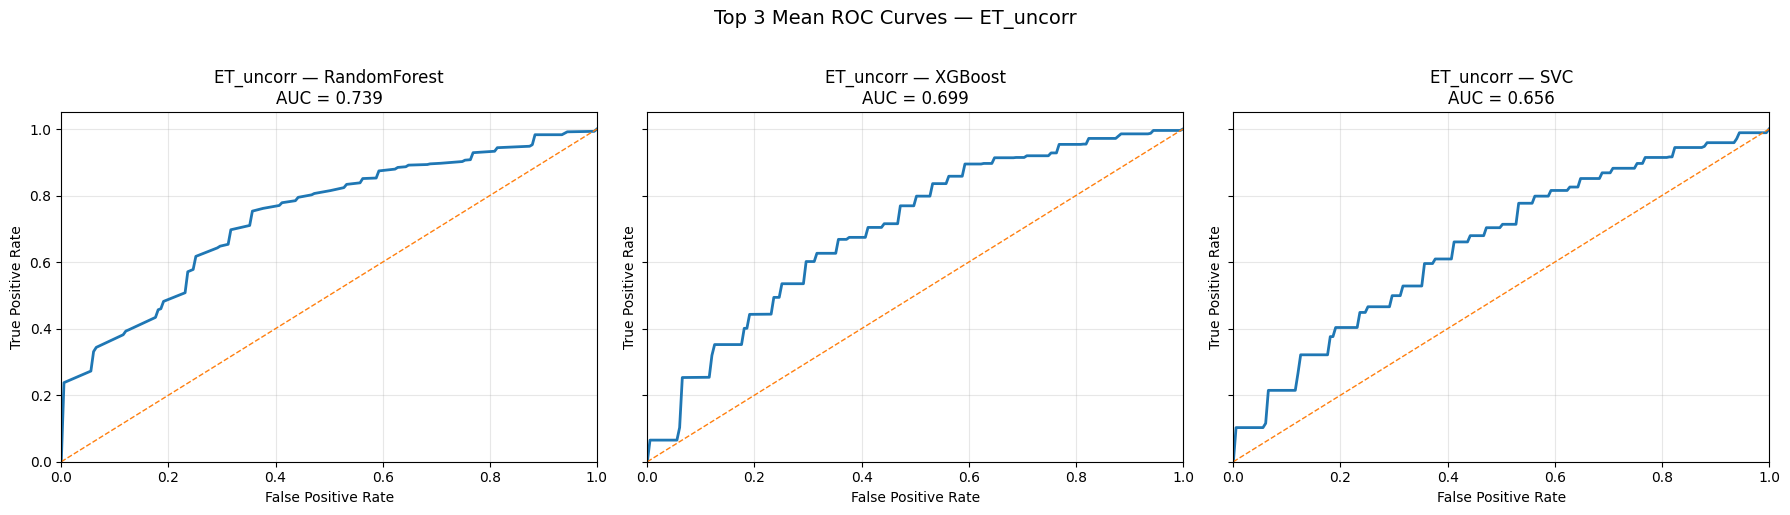

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:30] WARNI

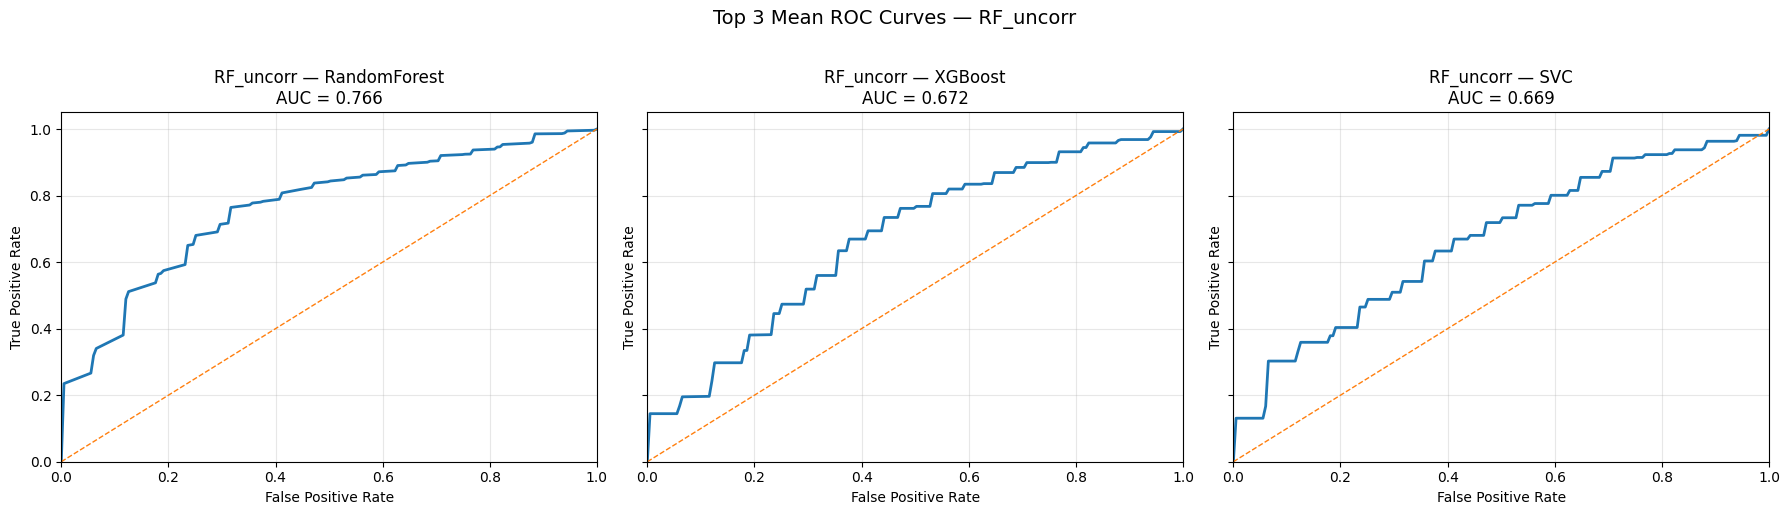

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:00:41] WARNI

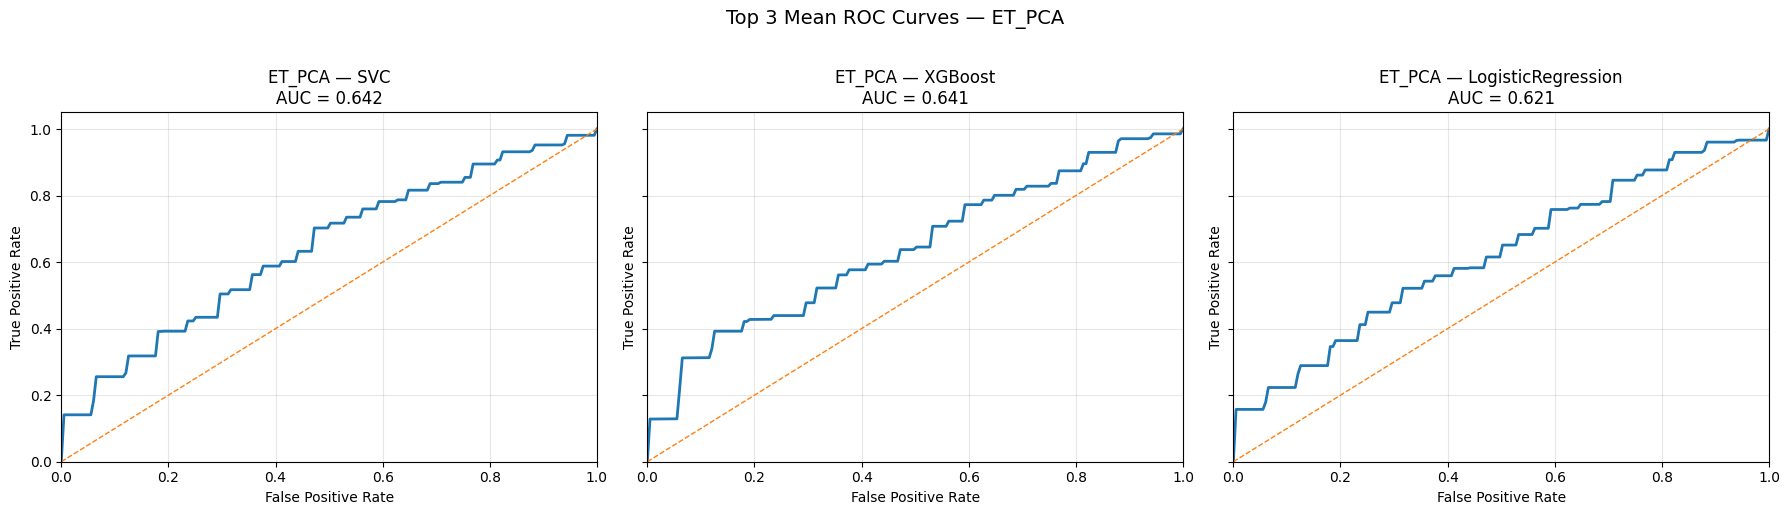

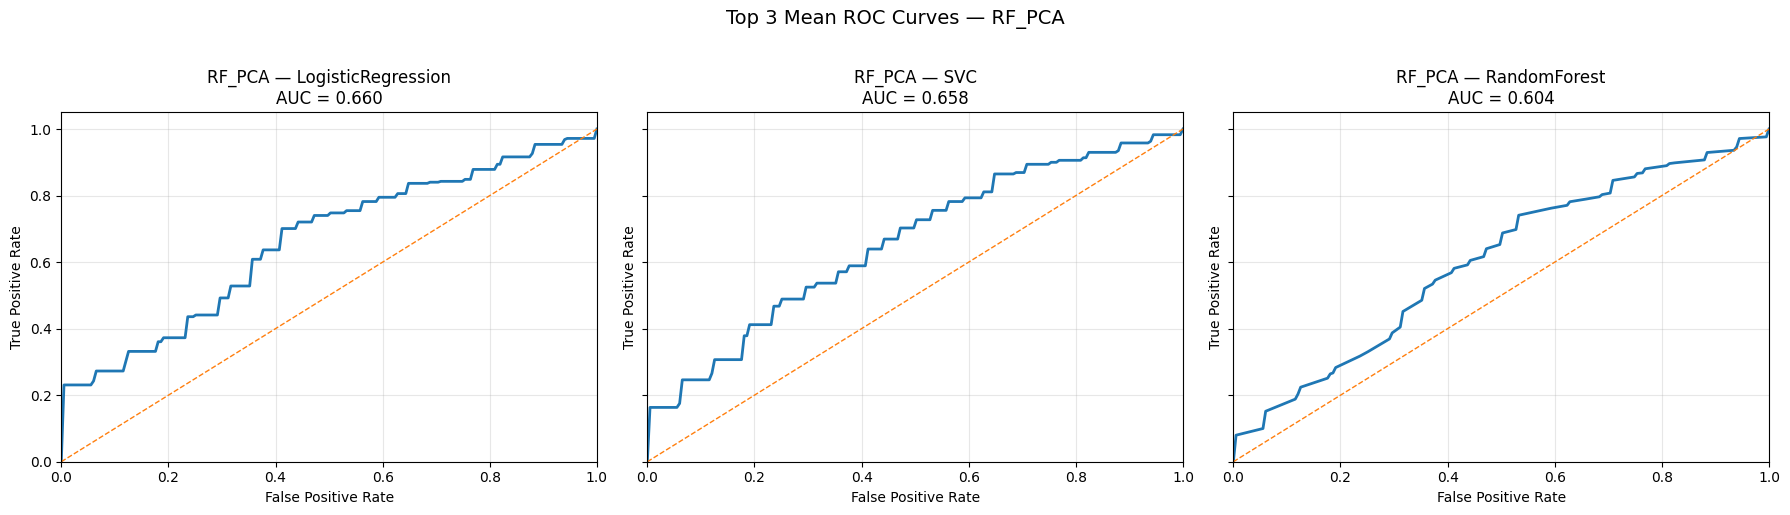

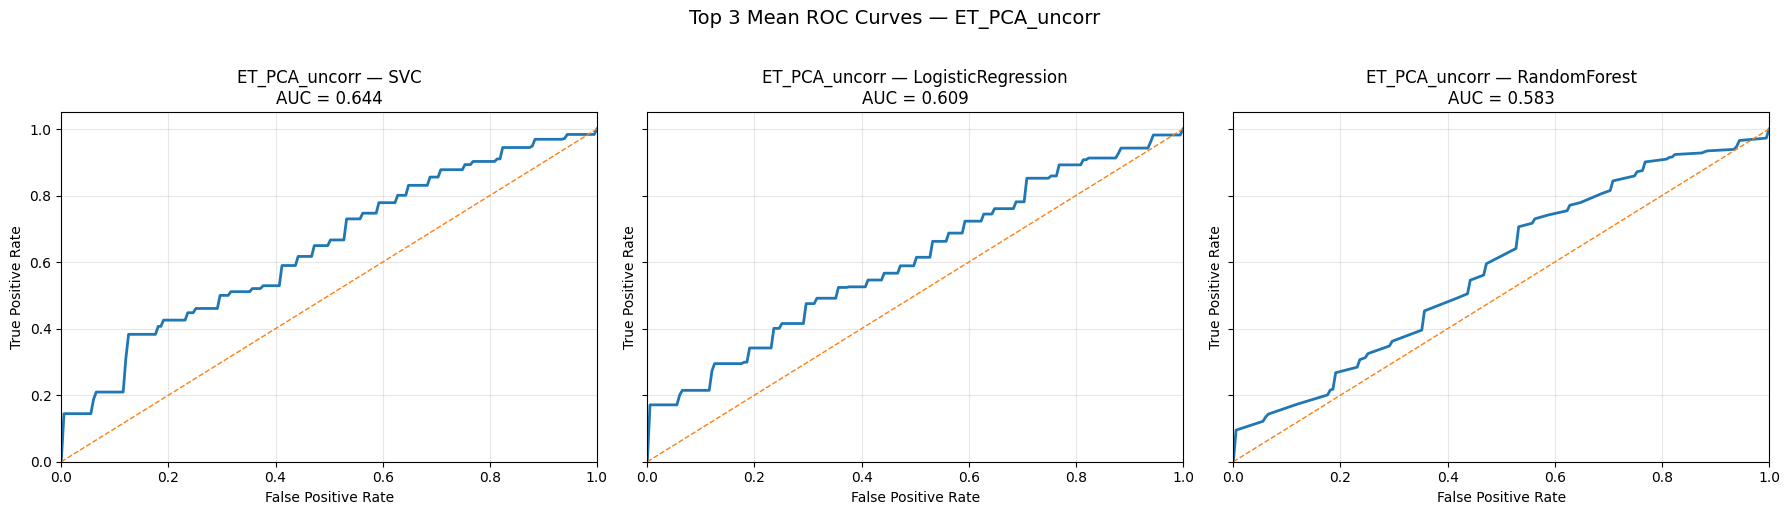

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:21] WARNI

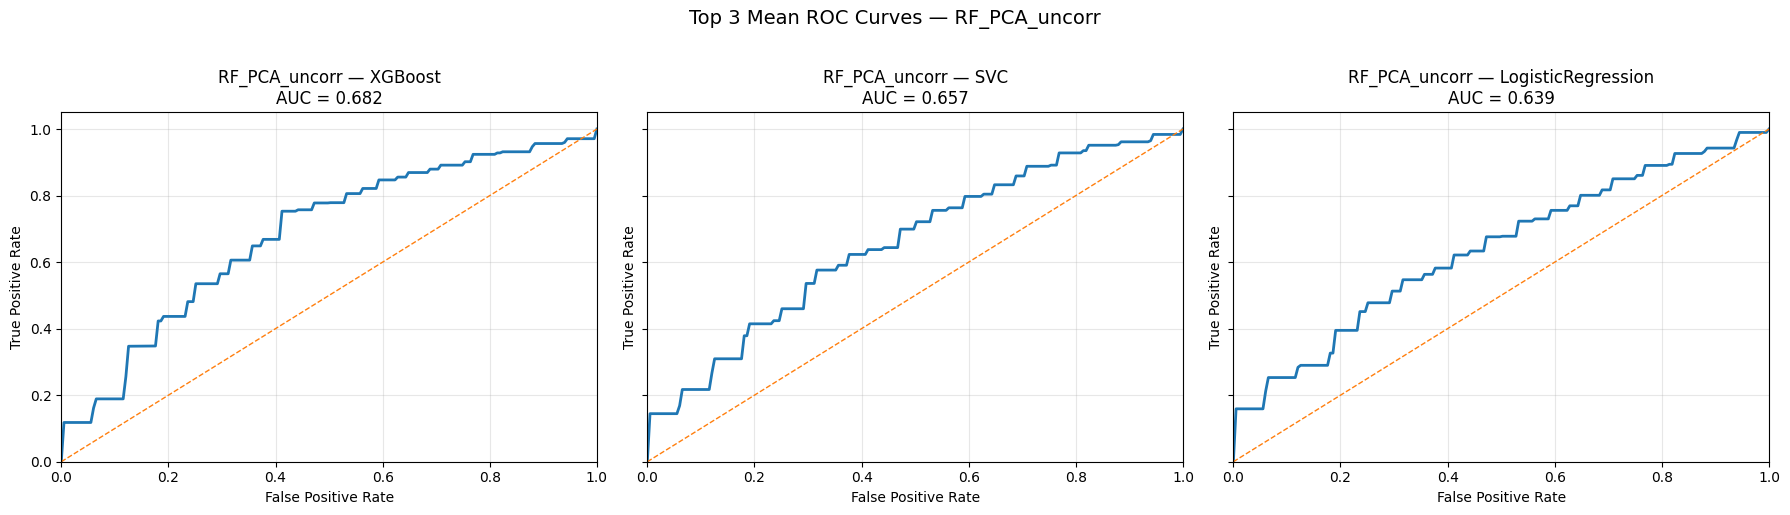

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:01:48] WARNI

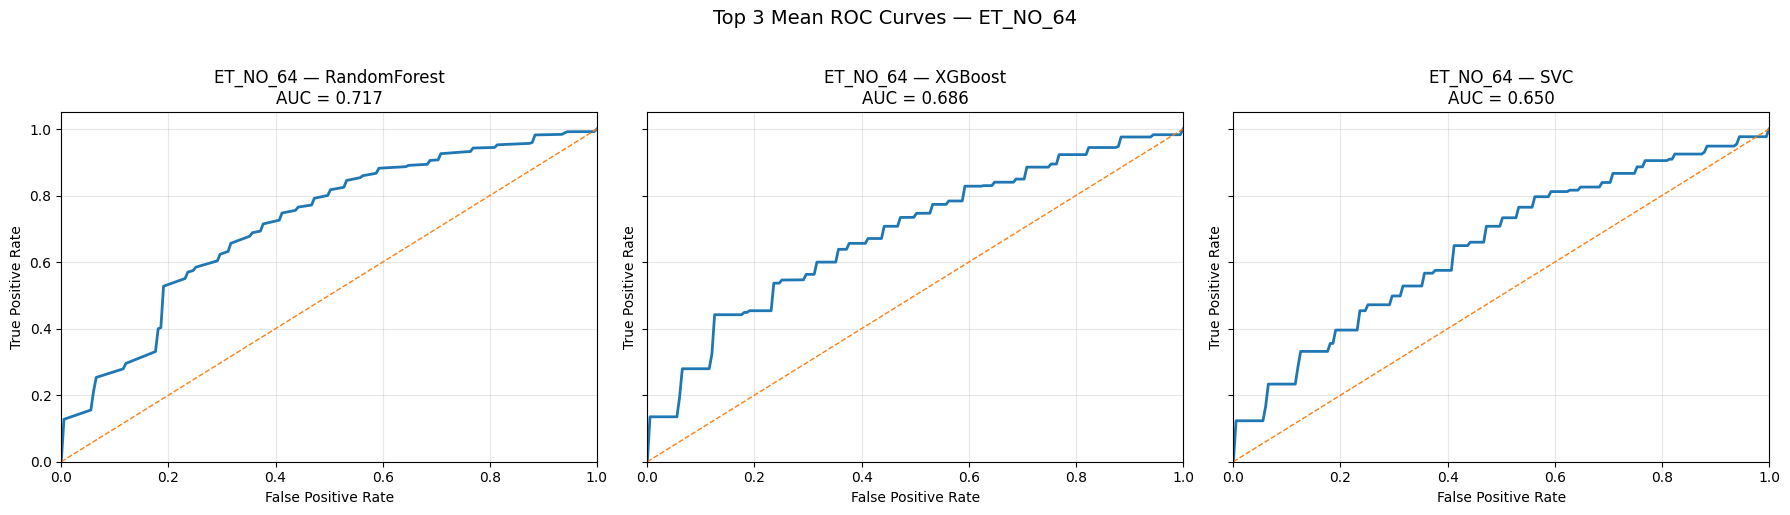

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:21] WARNI

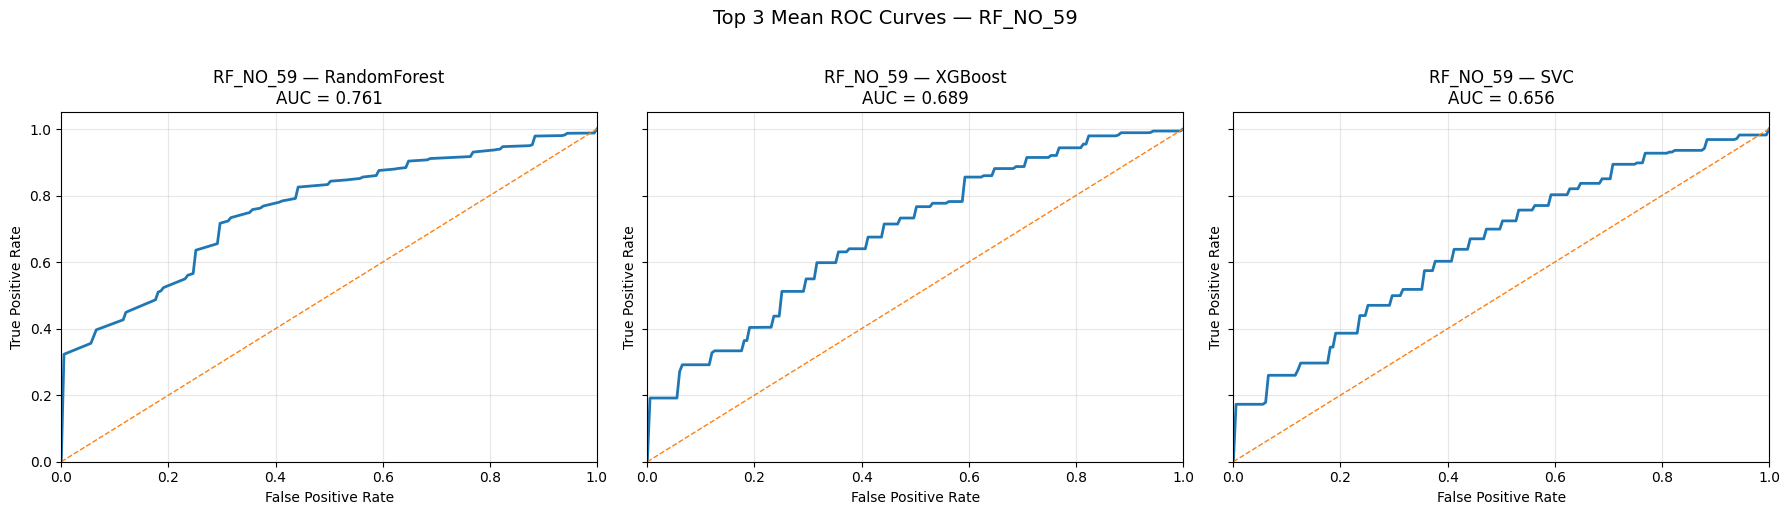

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:54] WARNI

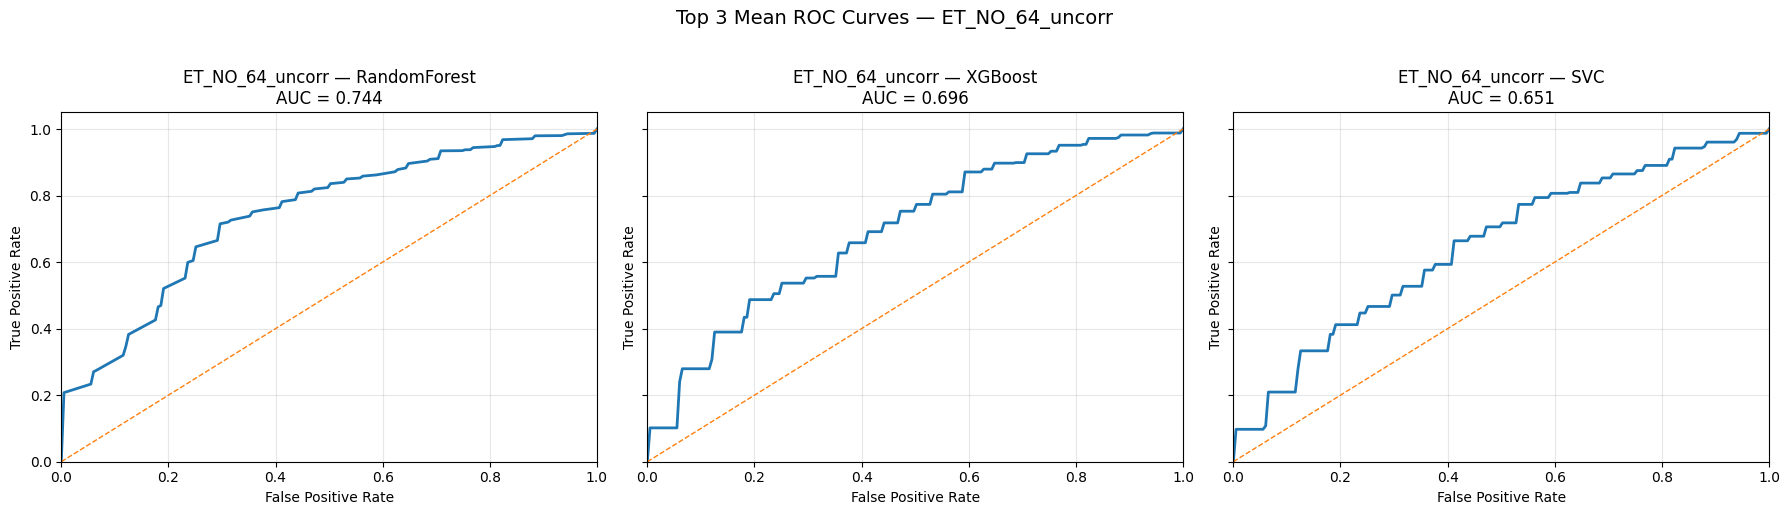

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:22] WARNI

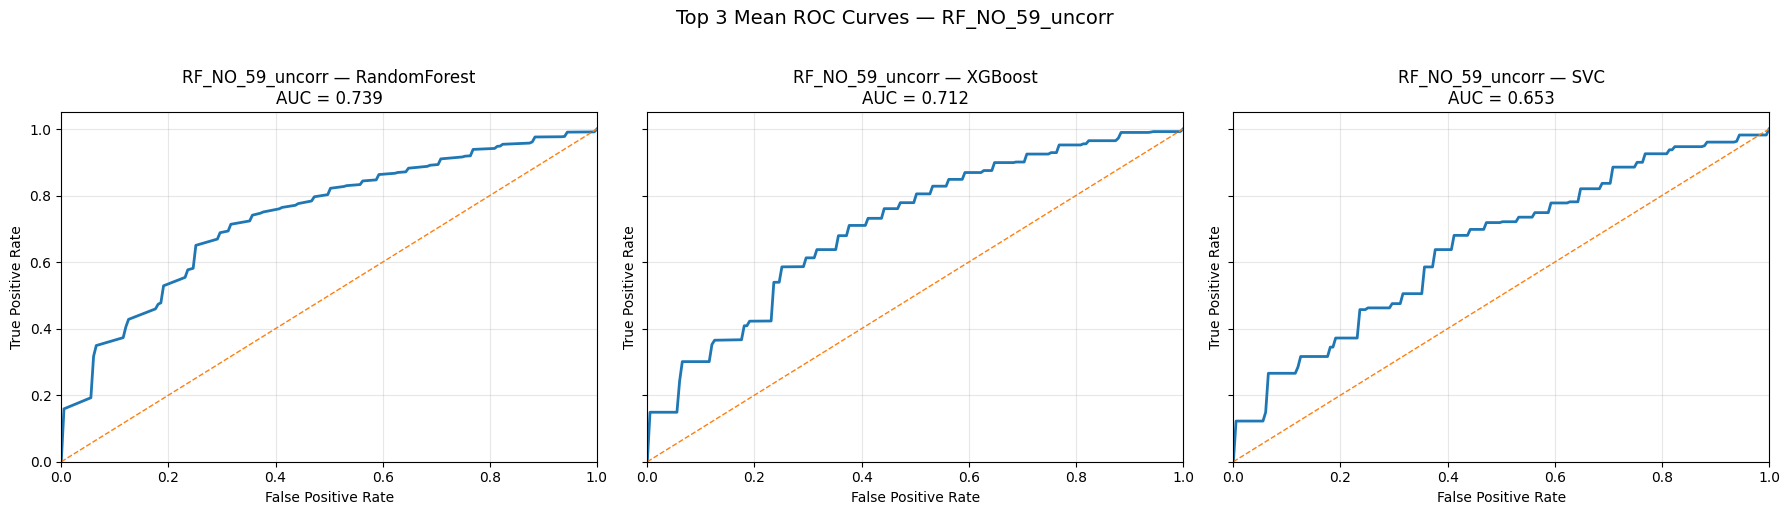

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:30] WARNI

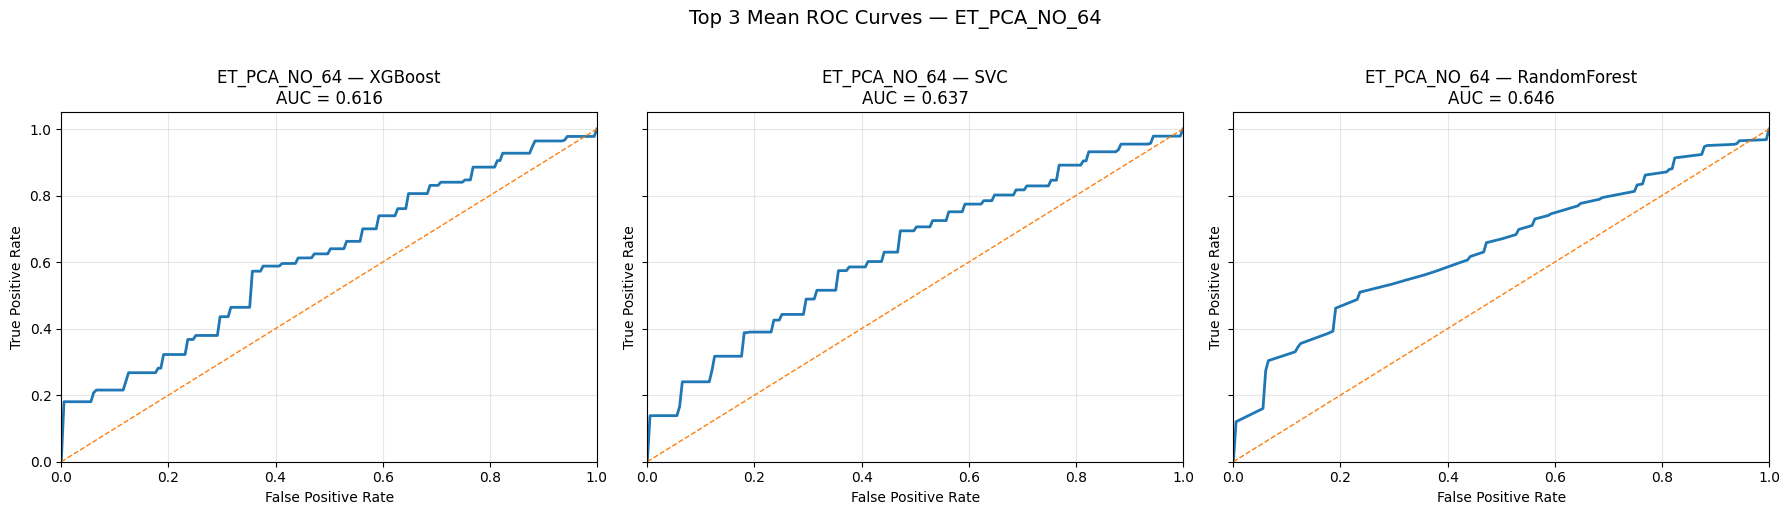

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:54] WARNI

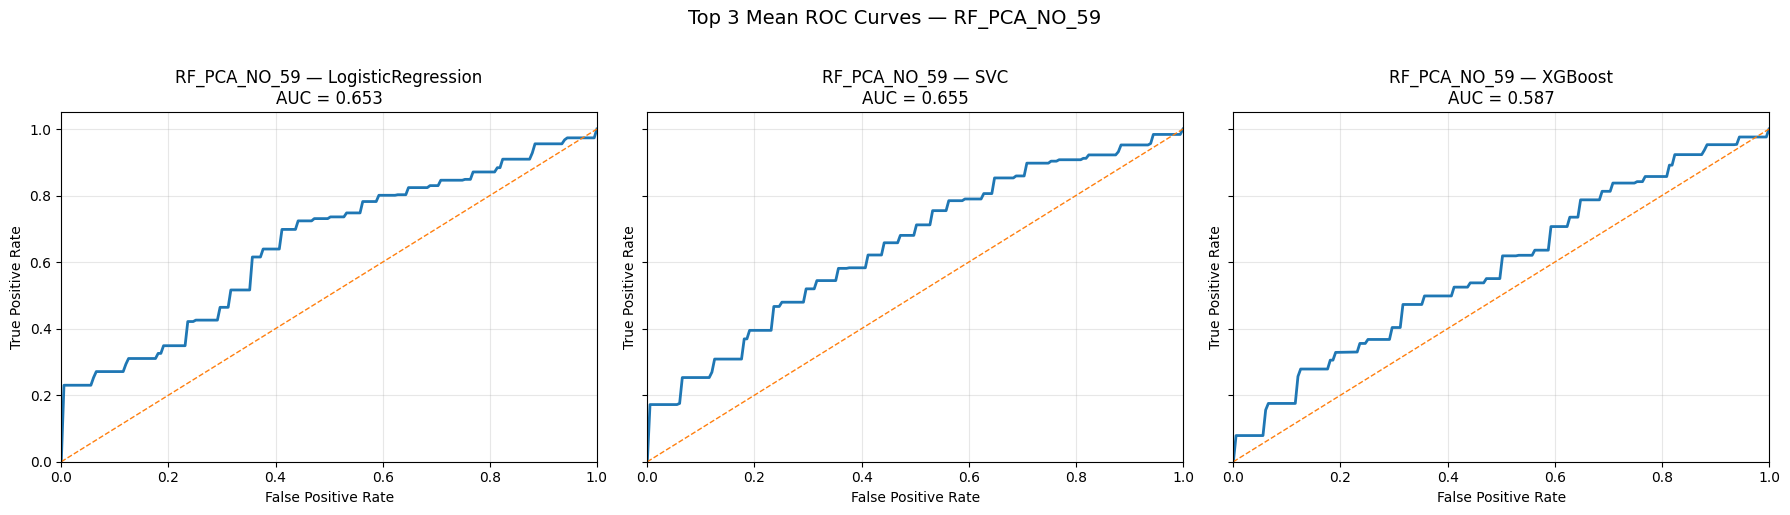

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:03:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:00] WARNI

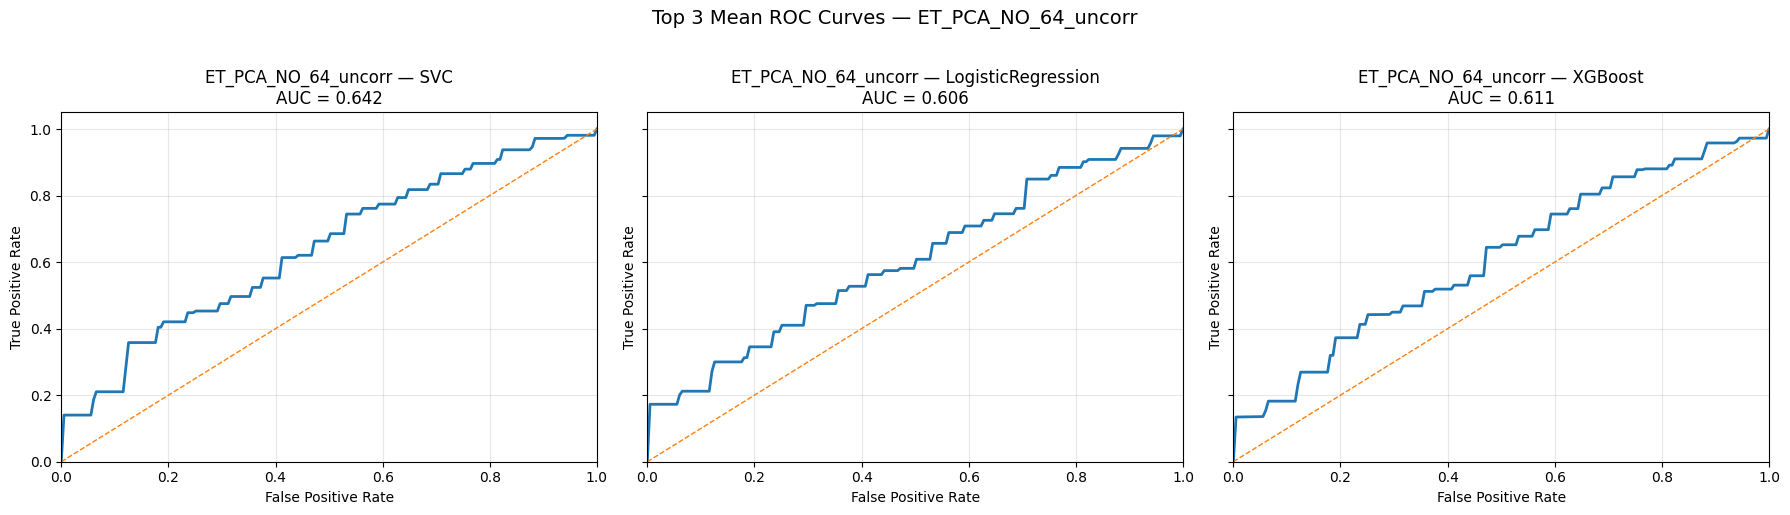

c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Abdullah\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:04:03] WARNI

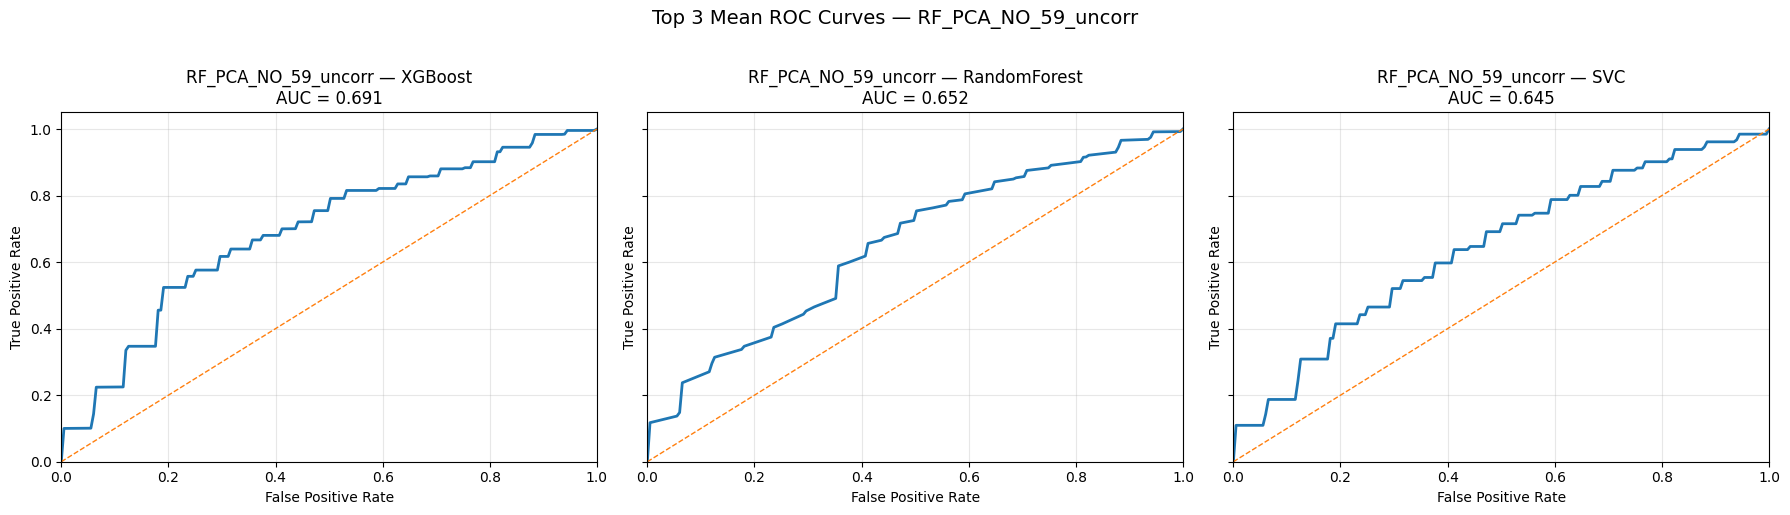

In [26]:
for name in splits.keys():
    plot_top3_roc_subplots(name)